<a href="https://colab.research.google.com/github/davemarco/CNN_Captcha_Solver/blob/main/Captcha_Solver_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Import

##Import dependencies



In [ ]:
import os, sys, shutil
import time
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils



import torch.utils.data as data

import torchvision
from torchvision import datasets, transforms

import cv2
from PIL import Image

import zipfile

%config InlineBackend.figure_format='retina'

%pip install captcha
from captcha.image import ImageCaptcha
import itertools
import uuid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 31.4 MB/s 


## Generate Captchas

In [ ]:
#dataset generate code taken from libary

def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

    image = ImageCaptcha(width=width, height=height)

    for counter in range(num_of_repetition):
        print('generating %d/%d' % (counter + 1, num_of_repetition))
        for i in itertools.permutations([str(c) for c in range(10)], num_of_letters):
            captcha = ''.join(i)
            fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
            image.write(captcha, fn)


def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')

In [ ]:
BATCH_SIZE = 128
NUM_OF_LETTERS = 5
EPOCHS = 50
IMG_ROW, IMG_COLS = 50, 135


# Non-configs
PATH = os.getcwd()
DATA_PATH = os.path.join(PATH, 'train')

In [ ]:
if not os.path.exists(DATA_PATH):
    print('Generating Dataset')
    gen_dataset(DATA_PATH, 1 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW)

Generating Dataset
generating 1/1
Finished Data Generation


## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 2. Prepare data for Model

## String to integer conversion functions

In [ ]:
char_number = 5

def String2Label(Str):
    label = []

    while(len(Str) < char_number):
      Str= Str + '0'
    for i in range(0, char_number):
        if Str[i] >= '0' and Str[i] <= '9':
            label.append(ord(Str[i]) - ord('0'))
        elif Str[i] >= 'a' and Str[i] <= 'z':
            label.append(ord(Str[i]) - ord('a') + 10)
        else:
            label.append(ord(Str[i]) - ord('A') + 36)
    return label


def Label2String(Label):
    Str = ""
    for i in Label:
        if i <= 9:
            Str += chr(ord('0') + i)
        elif i <= 35:
            Str += chr(ord('a') + i - 10)
        else:
            Str += chr(ord('A') + i - 36)
    return Str

# Wrapper class for CAPTCHA

In [ ]:
class CAPTCHA_get_data(torch.utils.data.Dataset):
    def __init__(self, root,Dotransforms = True):
        self.imgsPath = [os.path.join(root, img) for img in os.listdir(root)]
        #if DoTransforms is false, then do not modify dataset
        if (Dotransforms):
          self.transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
              transforms.Grayscale(1),
              transforms.Resize([25,67]),
              ])
        else:
          self.transform = transforms.Compose([
          transforms.ToTensor()])

    def __getitem__(self, index):
        imgPath = self.imgsPath[index]
        label = imgPath.split("/")[-1].split(".")[0]
        label_tensor = torch.Tensor(String2Label(label))
        data = self.transform(Image.open(imgPath))
        return data, label_tensor.long()

    def __len__(self):
        return len(self.imgsPath)

In [ ]:
dataset = CAPTCHA_get_data(f"/content/train/data")
train_set_size = int(len(dataset) * 0.6)
val_set_size = int(len(dataset) * 0.2)
test_set_size = int(len(dataset) - train_set_size - val_set_size)

In [ ]:
data_train, data_val, data_test = data.random_split(dataset, [train_set_size,val_set_size, test_set_size], generator=torch.Generator().manual_seed(42))

# 3. Neural Network Definitions

## ANN

In [ ]:
class CAPTCHA_BASELINE_ANN(nn.Module):
    def __init__(self):
        super(CAPTCHA_BASELINE_ANN, self).__init__()
        self.name = "CAPTCHA_BASELINE_ANN"
        self.fc1 = nn.Linear(67*25, 500)
        #self.fc2 = nn.Linear(1000, 500)
        self.fc31 = nn.Linear(500, 10)
        self.fc32 = nn.Linear(500, 10)
        self.fc33 = nn.Linear(500, 10)
        self.fc34 = nn.Linear(500, 10)
        self.fc35 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.view(-1,67*25)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x1 = self.fc31(x)
        x2 = self.fc32(x)
        x3 = self.fc33(x)
        x4 = self.fc34(x)
        x5 = self.fc35(x)
        return x1, x2, x3, x4, x5

## CNN + size calculations

In [ ]:
from math import floor
conv1 = 67-3 + 1
pool1 = floor(((conv1-2)/2)) +1
conv2= pool1 - 3 +1
pool2 = floor((conv2-2)/2) +1
conv3 = pool2 - 3 +1
pool3 = floor((conv3-2)/2) +1
pool3

6

In [ ]:

conv1 = 25 -3 + 1
pool1 = floor(((conv1-2)/2)) +1
conv2= pool1 - 3 +1
pool2 = floor((conv2-2)/2) +1
conv3 = pool2 - 3 +1
pool3 = floor((conv3-2)/2) +1
pool3

1

In [ ]:
6*1*64

384

In [ ]:
class CAPTCHA_BASELINE_CNN(nn.Module):
    def __init__(self):
        super(CAPTCHA_BASELINE_CNN, self).__init__()
        self.name = "CAPTCHA_BASELINE_CNN"
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=0) # in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv2d(32, 48, 3, stride=1, padding=0) # in_channels, out_chanels, kernel_size
        self.conv3 = nn.Conv2d(48, 64, 3, stride=1, padding=0) # in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) # kernel_size, stride
        self.fc1 = nn.Linear(384, 512)
        self.fc41 = nn.Linear(512, 10)
        self.fc42 = nn.Linear(512, 10)
        self.fc43 = nn.Linear(512, 10)
        self.fc44 = nn.Linear(512, 10)
        self.fc45 = nn.Linear(512, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 384)
        x = self.fc1(x)
        x = F.relu(x)
        x1 = self.fc41(x)
        x2 = self.fc42(x)
        x3 = self.fc43(x)
        x4 = self.fc44(x)
        x5 = self.fc45(x)
        return x1, x2, x3, x4, x5

# 4. Accurary function

In [ ]:
def get_accuracy(model, data, batch_size, use_cuda):
    correctt,correct1t,correct2t,correct3t,correct4t,correct5t  = 0,0,0,0,0,0
    total = 0
    outputArray = []
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################

        # output = model(imgs)
        y1, y2, y3, y4, y5 = model(imgs)
        # select index with maximum prediction score
        pred1 = y1.max(1, keepdim=True)[1]
        pred2 = y2.max(1, keepdim=True)[1]
        pred3 = y3.max(1, keepdim=True)[1]
        pred4 = y4.max(1, keepdim=True)[1]
        pred5 = y5.max(1, keepdim=True)[1]

        #labels = labels.squeeze()
        correct1 = pred1.eq(labels[:,0].view_as(pred1)).sum().item()
        correct2 = pred2.eq(labels[:,1].view_as(pred2)).sum().item()
        correct3 = pred3.eq(labels[:,2].view_as(pred3)).sum().item()
        correct4 = pred4.eq(labels[:,3].view_as(pred4)).sum().item()
        correct5 = pred5.eq(labels[:,4].view_as(pred5)).sum().item()

        pred = (torch.cat((pred1, pred2, pred3, pred4, pred5), dim=1))
        finalpred = []
        for pred in pred:
          finalpred.append(Label2String(pred))

        finalpred = np.array(finalpred)

        finallabel = []
        for labels in labels:
          finallabel.append(Label2String(labels))

        finallabel = np.array(finallabel)


        correct = sum(finalpred==finallabel)
        correctt += correct
        correct1t += correct1
        correct2t += correct2
        correct3t += correct3
        correct4t += correct4
        correct5t += correct5

        total += imgs.shape[0]

    return correctt / total, correct1t / total, correct2t / total, correct3t / total, correct4t / total, correct5t / total

#4. Training function

In [ ]:
def train(model, data_train, data_val, learning_rate=0.001, batch_size=64, \
          num_epochs=50, use_cuda=True, output_freq=10):

    torch.manual_seed(100)
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_accuracy,train_accuracy1, train_accuracy2,train_accuracy3,train_accuracy4,train_accuracy5 = [],[],[],[],[],[]
    val_accuracy,val_accuracy1, val_accuracy2,val_accuracy3,val_accuracy4,val_accuracy5 = [],[],[],[],[],[]
    losses = []

    for epoch in range(num_epochs):
        for n, (imgs, labels) in enumerate(iter(train_loader)):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################

            # label1, label2, label3, label4, label5 = labels[:, 0], labels[:, 1], \
            #                                          labels[:, 2], labels[:, 3], \
            #                                          labels[:, 4]
            label1, label2, label3, label4, label5 = [labels[:,i] for i in range(5)]

            # forward pass
            y1, y2, y3, y4, y5 = model(imgs)

            # compute the each loss
            loss1, loss2, loss3, loss4, loss5 = criterion(y1, label1), criterion(y2, label2), \
                                                criterion(y3, label3), criterion(y4, label4), \
                                                criterion(y5, label5)

            # compute the total loss
            loss = loss1 + loss2 + loss3 + loss4 + loss5
            # compute average loss
            avg_loss = loss.item()


            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # compute *average* loss
        losses.append(avg_loss)

        # compute training accuracy
        A,A1,A2,A3,A4,A5 = get_accuracy(model, data_train, batch_size=batch_size, use_cuda=True)
        train_accuracy.append(A)
        train_accuracy1.append(A1)
        train_accuracy2.append(A2)
        train_accuracy3.append(A3)
        train_accuracy4.append(A4)
        train_accuracy5.append(A5)

        # compute validation accuracy
        V,V1,V2,V3,V4,V5 = get_accuracy(model, data_val, batch_size=batch_size, use_cuda=True)
        val_accuracy.append(V)
        val_accuracy1.append(V1)
        val_accuracy2.append(V2)
        val_accuracy3.append(V3)
        val_accuracy4.append(V4)
        val_accuracy5.append(V5)

        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
        if not epoch % output_freq:
            print(f"Epoch: {epoch:0=2d} -> Train Acc: {train_accuracy[epoch]:.4f} | Val Acc: {val_accuracy[epoch]:.4f}")
            print(f"Digits Train Acc: {train_accuracy1[epoch]:.2f} {train_accuracy2[epoch]:.2f} {train_accuracy3[epoch]:.2f} {train_accuracy4[epoch]:.2f} {train_accuracy5[epoch]:.2f}| Digits Val Acc: {val_accuracy1[epoch]:.2f} {val_accuracy2[epoch]:.2f} {val_accuracy3[epoch]:.2f} {val_accuracy4[epoch]:.2f} {val_accuracy5[epoch]:.2f}")
    plot_training_curve(train_accuracy, val_accuracy, losses)
    plot_digits_curve(train_accuracy1,train_accuracy2,train_accuracy3,train_accuracy4,train_accuracy5, val_accuracy1,val_accuracy2,val_accuracy3,val_accuracy4,val_accuracy5)
    print("Final Training Accuracy: {}".format(train_accuracy[-1]))
    print("Final Validation Accuracy: {}".format(val_accuracy[-1]))

## Curve plotting

In [ ]:
def plot_training_curve(train_accuracy, val_accuracy, train_loss):
    n = len(train_accuracy) # number of epochs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(range(1,n+1), train_accuracy, label="Train")
    ax1.plot(range(1,n+1), val_accuracy, label="Validation")
    ax1.title.set_text("Train vs Validation Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='best')
    ax2.plot(range(1,n+1), train_loss, label="Train")
    # ax2.plot(range(1,n+1), val_loss, label="Validation")
    ax2.title.set_text("Train Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend(loc='best')
    fig.tight_layout()
    plt.show()
    fig.savefig('./training_curve.svg', dpi=1200, bbox_inches='tight', format='svg')

In [ ]:
def plot_digits_curve(train_accuracy1,train_accuracy2,train_accuracy3,train_accuracy4,train_accuracy5, val_accuracy1,val_accuracy2,val_accuracy3,val_accuracy4,val_accuracy5):
    n = len(train_accuracy1) # number of epochs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(range(1,n+1), train_accuracy1, label="Digit1")
    ax1.plot(range(1,n+1), train_accuracy2, label="Digit2")
    ax1.plot(range(1,n+1), train_accuracy3, label="Digit3")
    ax1.plot(range(1,n+1), train_accuracy4, label="Digit4")
    ax1.plot(range(1,n+1), train_accuracy5, label="Digit5")

    ax1.title.set_text("Train Digit Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='best')
    ax2.plot(range(1,n+1), val_accuracy1, label="Digit1")
    ax2.plot(range(1,n+1), val_accuracy2, label="Digit2")
    ax2.plot(range(1,n+1), val_accuracy3, label="Digit3")
    ax2.plot(range(1,n+1), val_accuracy4, label="Digit4")
    ax2.plot(range(1,n+1), val_accuracy5, label="Digit5")
    # ax2.plot(range(1,n+1), val_loss, label="Validation")
    ax2.title.set_text("Validation Digit Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc='best')
    fig.tight_layout()
    plt.show()
    fig.savefig('./digits_curve.svg', dpi=1200, bbox_inches='tight', format='svg')

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    return f"model_{name}_bs{batch_size}_lr{learning_rate}_epoch{epoch}"

In [ ]:
!nvidia-smi
use_cuda = True


Mon Nov 21 17:36:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    48W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#5. ANN Model Training

The number of parameters to be trained: 863050

CUDA is available! Training on GPU ...

Epoch: 00 -> Train Acc: 0.0001 | Val Acc: 0.0002
Digits Train Acc: 0.23 0.19 0.10 0.14 0.18| Digits Val Acc: 0.21 0.18 0.11 0.14 0.17
Epoch: 01 -> Train Acc: 0.0012 | Val Acc: 0.0013
Digits Train Acc: 0.39 0.16 0.23 0.24 0.29| Digits Val Acc: 0.38 0.16 0.21 0.23 0.29
Epoch: 02 -> Train Acc: 0.0045 | Val Acc: 0.0045
Digits Train Acc: 0.48 0.25 0.28 0.29 0.37| Digits Val Acc: 0.46 0.23 0.26 0.28 0.36
Epoch: 03 -> Train Acc: 0.0097 | Val Acc: 0.0073
Digits Train Acc: 0.51 0.30 0.28 0.37 0.48| Digits Val Acc: 0.49 0.30 0.26 0.34 0.47
Epoch: 04 -> Train Acc: 0.0180 | Val Acc: 0.0127
Digits Train Acc: 0.57 0.37 0.35 0.40 0.53| Digits Val Acc: 0.55 0.34 0.32 0.36 0.49
Epoch: 05 -> Train Acc: 0.0197 | Val Acc: 0.0132
Digits Train Acc: 0.59 0.38 0.34 0.40 0.49| Digits Val Acc: 0.56 0.35 0.31 0.37 0.47
Epoch: 06 -> Train Acc: 0.0264 | Val Acc: 0.0182
Digits Train Acc: 0.56 0.40 0.37 0.40 0.56| Digits Val Acc:

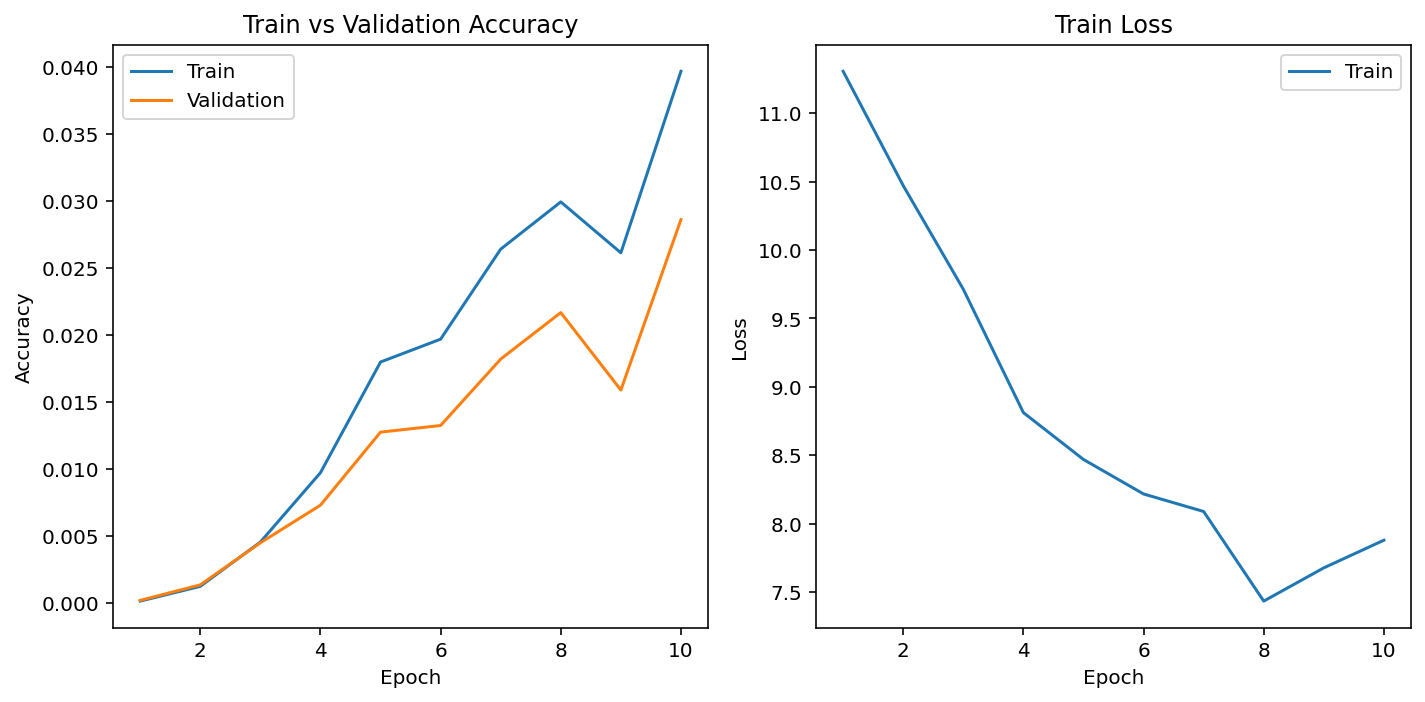

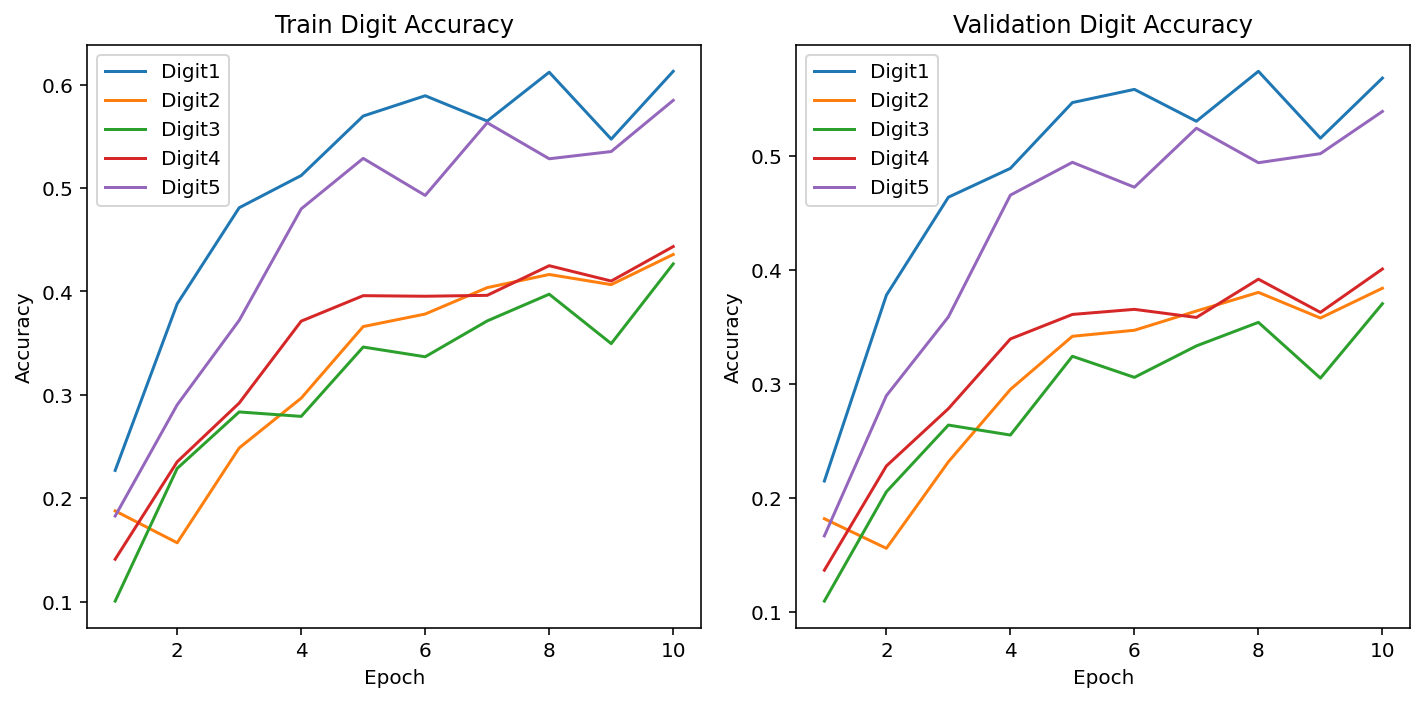

Final Training Accuracy: 0.03968253968253968
Final Validation Accuracy: 0.028604497354497355


In [ ]:
model_baseline = CAPTCHA_BASELINE_ANN()
params = sum(p.numel() for p in model_baseline.parameters() if p.requires_grad)
print(f"The number of parameters to be trained: {params}")

if torch.cuda.is_available():
    model_baseline.cuda()
    print('\nCUDA is available! Training on GPU ...\n')
else:
    print('\nCUDA is not available. Training on CPU ...\n')

train(model_baseline, data_train, data_val, learning_rate=.001,
      batch_size=32, num_epochs=10, use_cuda=True, output_freq=1)

# 7. CNN Model Training

The number of parameters to be trained: 264674

CUDA is available! Training on GPU ...

Epoch: 00 -> Train Acc: 0.0002 | Val Acc: 0.0000
Digits Train Acc: 0.19 0.18 0.16 0.18 0.21| Digits Val Acc: 0.19 0.18 0.17 0.18 0.21
Epoch: 01 -> Train Acc: 0.2543 | Val Acc: 0.2131
Digits Train Acc: 0.84 0.71 0.67 0.72 0.80| Digits Val Acc: 0.81 0.69 0.64 0.69 0.79
Epoch: 02 -> Train Acc: 0.6119 | Val Acc: 0.5332
Digits Train Acc: 0.93 0.89 0.88 0.88 0.90| Digits Val Acc: 0.92 0.87 0.84 0.86 0.88
Epoch: 03 -> Train Acc: 0.7711 | Val Acc: 0.6733
Digits Train Acc: 0.97 0.94 0.94 0.94 0.94| Digits Val Acc: 0.95 0.91 0.90 0.91 0.91
Epoch: 04 -> Train Acc: 0.8282 | Val Acc: 0.7092
Digits Train Acc: 0.97 0.97 0.95 0.96 0.95| Digits Val Acc: 0.94 0.94 0.91 0.92 0.92
Epoch: 05 -> Train Acc: 0.8141 | Val Acc: 0.6949
Digits Train Acc: 0.98 0.96 0.94 0.95 0.96| Digits Val Acc: 0.96 0.92 0.90 0.92 0.92
Epoch: 06 -> Train Acc: 0.8759 | Val Acc: 0.7353
Digits Train Acc: 0.98 0.97 0.97 0.97 0.97| Digits Val Acc:

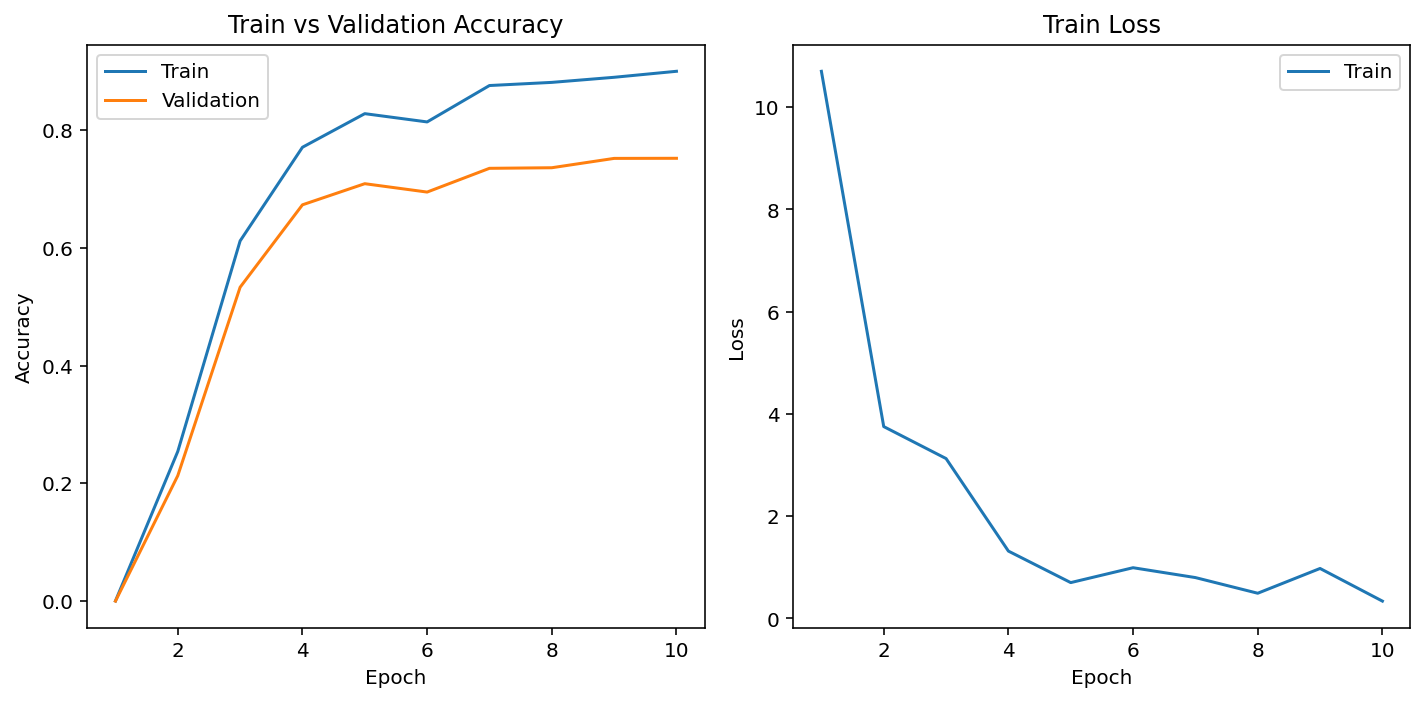

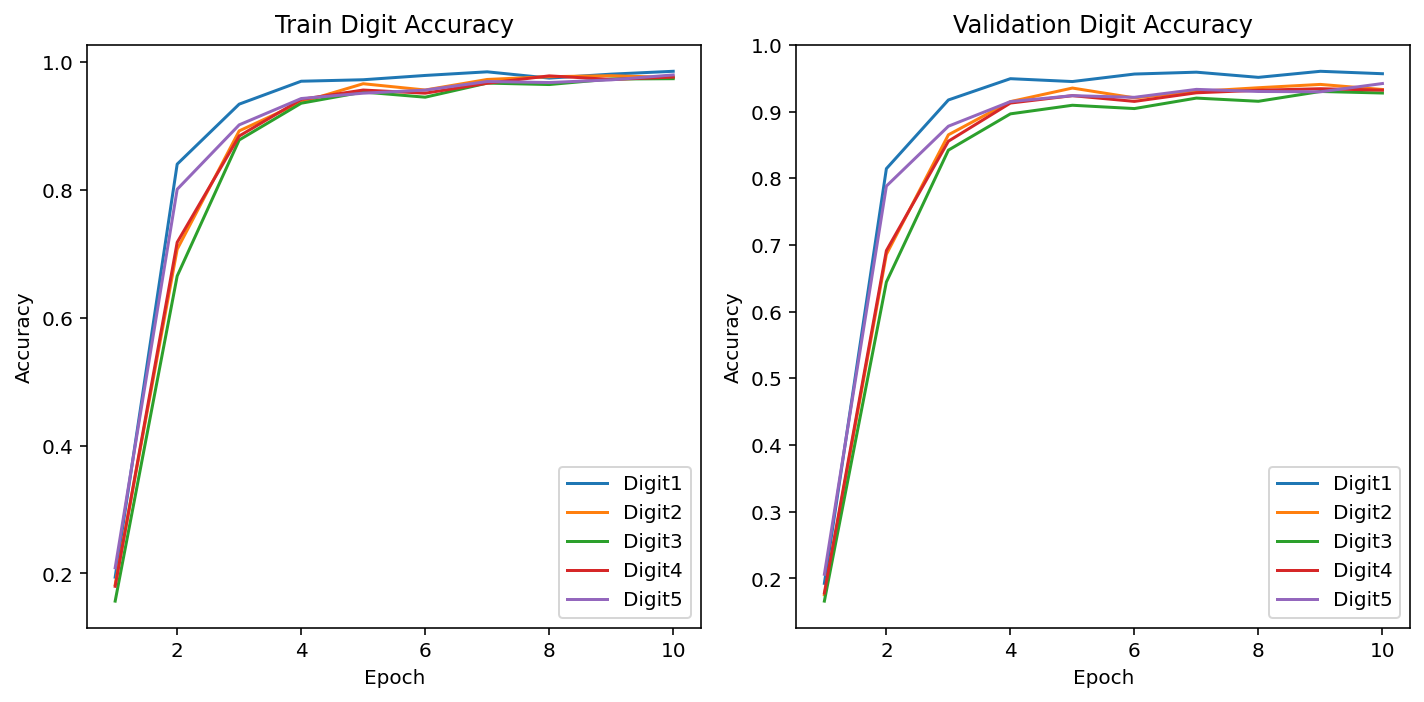

Final Training Accuracy: 0.9001322751322751
Final Validation Accuracy: 0.7523148148148148


In [ ]:
model_baseline = CAPTCHA_BASELINE_CNN()
params = sum(p.numel() for p in model_baseline.parameters() if p.requires_grad)
print(f"The number of parameters to be trained: {params}")

if torch.cuda.is_available():
    model_baseline.cuda()
    print('\nCUDA is available! Training on GPU ...\n')
else:
    print('\nCUDA is not available. Training on CPU ...\n')

train(model_baseline, data_train, data_val, learning_rate=1e-2,
      batch_size=32, num_epochs=10, use_cuda=True, output_freq=1)

# 6. Alex Net Data Import



In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
class CAPTCHA_get_alex_data(torch.utils.data.Dataset):
    def __init__(self, root,Dotransforms = True):
        self.imgsPath = [os.path.join(root, img) for img in os.listdir(root)]
        #if DoTransforms is false, then do not modify dataset
        if (Dotransforms):
          #remove grayscale, convert to correct size
          self.transform = transforms.Compose([
              transforms.ToTensor(),

              transforms.Resize([224,224])
              ])
          #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        else:
          self.transform = transforms.Compose([
          transforms.ToTensor()])

    def __getitem__(self, index):
        imgPath = self.imgsPath[index]
        label = imgPath.split("/")[-1].split(".")[0]
        label_tensor = torch.Tensor(String2Label(label))
        data = self.transform(Image.open(imgPath))
        return data, label_tensor.long()

    def __len__(self):
        return len(self.imgsPath)

In [ ]:
alex_dataset = CAPTCHA_get_alex_data((f"/content/train/data"))

In [ ]:
dataset_loader = torch.utils.data.DataLoader(alex_dataset)

os.chdir("alex_dataset")
for image, label in dataset_loader:
  features = alexnet.features(image)
  features_adjusted = torch.from_numpy(features.detach().numpy())
  torch.save(features_adjusted,Label2String(label.squeeze()))

os.chdir('..')

In [ ]:
class CAPTCHA_get_alex_post_data(torch.utils.data.Dataset):
    def __init__(self, root,Dotransforms = True):
        self.imgsPath = [os.path.join(root, img) for img in os.listdir(root)]

    def __getitem__(self, index):
        imgPath = self.imgsPath[index]
        label = imgPath.split("/")[-1].split(".")[0]
        label_tensor = torch.Tensor(String2Label(label))
        data = torch.load(imgPath)
        return data, label_tensor.long()

    def __len__(self):
        return len(self.imgsPath)

In [ ]:
alex_post_dataset = CAPTCHA_get_alex_post_data((f"/content/alex_dataset"))

In [ ]:
train_set_size = int(len(alex_post_dataset) * 0.6)
val_set_size = int(len(alex_post_dataset) * 0.2)
test_set_size = int(len(alex_post_dataset) - train_set_size - val_set_size)

In [ ]:
alex_data_train, alex_data_val, alex_data_test = data.random_split(alex_post_dataset, [train_set_size,val_set_size, test_set_size], generator=torch.Generator().manual_seed(42))

In [ ]:
class CAPTCHA_ALEXNET(nn.Module):
    def __init__(self):
        super(CAPTCHA_ALEXNET, self).__init__()
        self.name = "CAPTCHA_ALEXNET"
        # self.conv1 = nn.Conv2d(25, 256, 1, 1)
        #self.pool = nn.MaxPool2d(2, 2)
        #self.fc1 = nn.Linear(256*6*6, 400)
        #self.conv1 = nn.Conv2d(256,256, 3, stride=1, padding=0) # in_channels, out_chanels, kernel_size

        self.fc21 = nn.Linear(256*6*6, 10)
        self.fc22 = nn.Linear(256*6*6, 10)
        self.fc23 = nn.Linear(256*6*6, 10)
        self.fc24 = nn.Linear(256*6*6, 10)
        self.fc25 = nn.Linear(256*6*6, 10)

    def forward(self, x):
        #x = x.squeeze(1)
        #print(x.shape)
        #x = torch.movedim(x,0,3)
        #x = torch.movedim(x,0,2)
        #print(x.shape)
        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 256*6*6)
        #x = F.relu(self.fc1(x))
        x1 = self.fc21(x)
        x2 = self.fc22(x)
        x3 = self.fc23(x)
        x4 = self.fc24(x)
        x5 = self.fc25(x)
        return x1, x2, x3, x4, x5

The number of parameters to be trained: 460850

CUDA is available! Training on GPU ...

Epoch: 00 -> Train Acc: 0.0153 | Val Acc: 0.0088
Digits Train Acc: 0.54 0.38 0.32 0.39 0.47| Digits Val Acc: 0.51 0.32 0.28 0.34 0.44
Epoch: 01 -> Train Acc: 0.0298 | Val Acc: 0.0127
Digits Train Acc: 0.63 0.44 0.42 0.43 0.55| Digits Val Acc: 0.56 0.33 0.32 0.35 0.49
Epoch: 02 -> Train Acc: 0.0461 | Val Acc: 0.0193
Digits Train Acc: 0.61 0.43 0.43 0.47 0.67| Digits Val Acc: 0.52 0.33 0.32 0.38 0.58
Epoch: 03 -> Train Acc: 0.0531 | Val Acc: 0.0215
Digits Train Acc: 0.71 0.49 0.41 0.45 0.72| Digits Val Acc: 0.60 0.38 0.31 0.35 0.61
Epoch: 04 -> Train Acc: 0.0651 | Val Acc: 0.0215
Digits Train Acc: 0.69 0.47 0.51 0.53 0.65| Digits Val Acc: 0.58 0.33 0.35 0.40 0.56
Epoch: 05 -> Train Acc: 0.0432 | Val Acc: 0.0177
Digits Train Acc: 0.66 0.38 0.42 0.48 0.71| Digits Val Acc: 0.56 0.29 0.31 0.36 0.59
Epoch: 06 -> Train Acc: 0.0909 | Val Acc: 0.0251
Digits Train Acc: 0.81 0.59 0.46 0.50 0.64| Digits Val Acc:

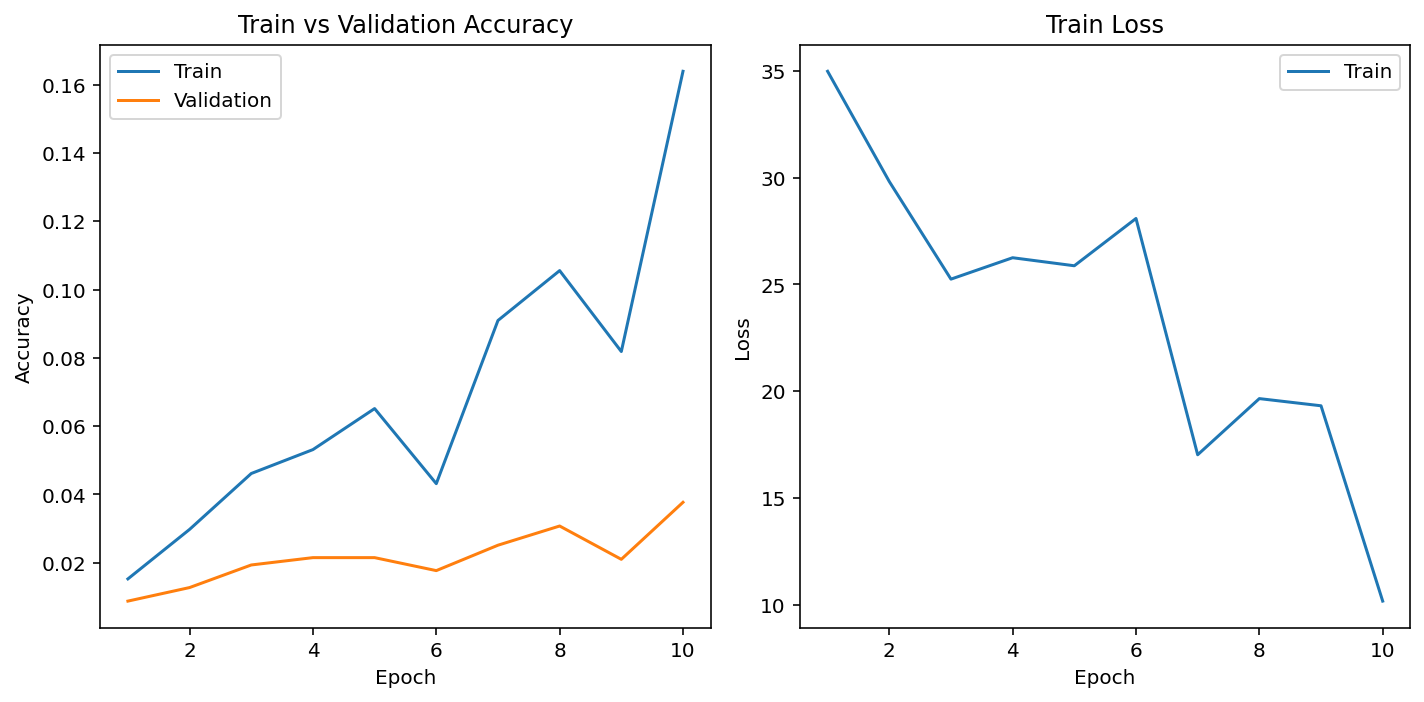

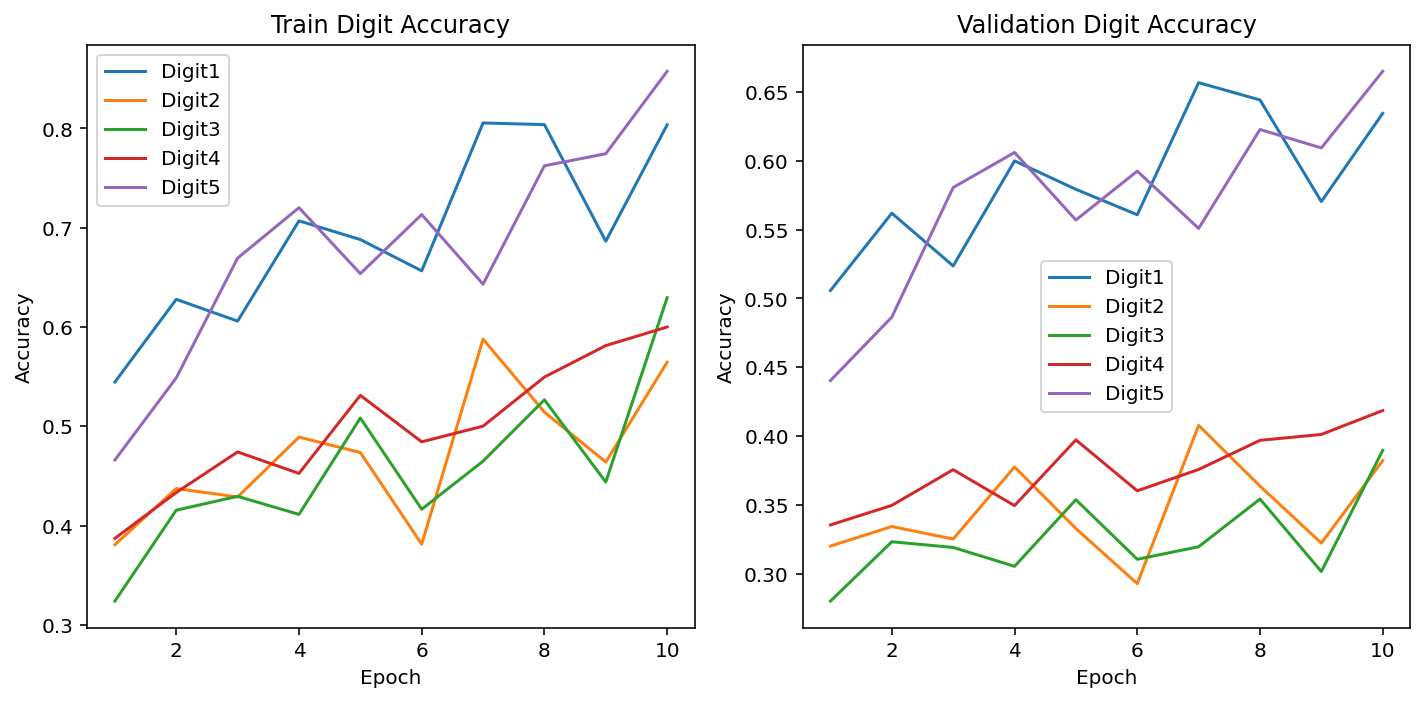

Final Training Accuracy: 0.16391093474426807
Final Validation Accuracy: 0.037698412698412696


In [ ]:
model_primary = CAPTCHA_ALEXNET()
params = sum(p.numel() for p in model_primary.parameters() if p.requires_grad)
print(f"The number of parameters to be trained: {params}")

if torch.cuda.is_available():
    model_primary.cuda()
    print('\nCUDA is available! Training on GPU ...\n')
else:
    print('\nCUDA is not available. Training on CPU ...\n')

train(model_primary, alex_data_train, alex_data_val, learning_rate=1e-2,
      batch_size=32, num_epochs=10, use_cuda=True, output_freq=1)